##### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href=https://developers.generativeai.google/examples/anomaly_detection"><img src="https://developers.generativeai.google/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/examples/anomaly_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href=" https://github.com/google/generative-ai-docs/blob/main/site/en/examples/anomaly_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the PaLM API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and detect outliers outside a particular radius of the central point of each categorical cluster.

For more information on getting started with embeddings generated from the PaLM API, check out the [quickstart](../tutorials/embeddings_quickstart.ipynb).

## Setup

First, download and install the PaLM API Python library.

In [ ]:
!pip install -q google-generativeai

In [ ]:
import google.generativeai as palm

import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

### Grab an API Key

To get started, you'll need to [create an API key](/tutorials/setup).

In [ ]:
palm.configure(api_key='PALM_KEY')

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

**Note**: At this time, the PaLM API is only available in the US.

In [ ]:
models = [m for m in palm.list_models() if 'embedText' in m.supported_generation_methods]

model = models[0]

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [ ]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [ ]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,Re: The Old Key Registration Idea...\nOrganiz...,11,sci.crypt
1,1651,Re: What the clipper nay-sayers sound like to...,11,sci.crypt
2,1652,Re: White House Public Encryption Management ...,11,sci.crypt
3,1653,Re: Clipper Chip and crypto key-escrow\nOrgan...,11,sci.crypt
4,1654,Marc VanHeyningen <>Re: Clipper chip -- techni...,11,sci.crypt
...,...,...,...,...
595,2245,"Re: Space Station Redesign, JSC Alternative #...",14,sci.space
596,2246,Re: Level 5?\nOrganization: U of Toronto Zool...,14,sci.space
597,2247,Space FAQ 15/15 - Orbital and Planetary Launc...,14,sci.space
598,2248,Nasa incentives\nX-Added: Forwarded by Space ...,14,sci.space


In [ ]:
df_train['Class Name'].value_counts()

sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: Class Name, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the PaLM API.

In [ ]:
from google.api_core import retry

# Define a function with automatic retry logic to compute embeddings and wait
# a bit once the quota limit has been reached.
@retry.Retry(timeout=300.0)
def embed_text(model, text):
  x = palm.generate_embeddings(model=model, text=text)
  return np.array(x['embedding'])

# Create embeddings for each document and add that as a column to the dataframe
tqdm.tqdm.pandas()
df_train['Embeddings'] = df_train['Text'].progress_apply(lambda x: embed_text(model=model,
                                                                              text=x))
df_train.drop('index', axis=1, inplace=True)

100%|██████████| 600/600 [04:10<00:00,  2.39it/s]


## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [ ]:
len(df_train['Embeddings'][0])

768

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [ ]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-22.163635,19.868490,sci.crypt
1,-7.135291,26.222147,sci.crypt
2,-21.182516,30.351313,sci.crypt
3,-16.046413,22.734932,sci.crypt
4,-19.539093,22.545391,sci.crypt
...,...,...,...
595,-10.613983,-23.675396,sci.space
596,7.599044,-12.451307,sci.space
597,-7.096947,-15.042100,sci.space
598,-0.572135,-19.784580,sci.space


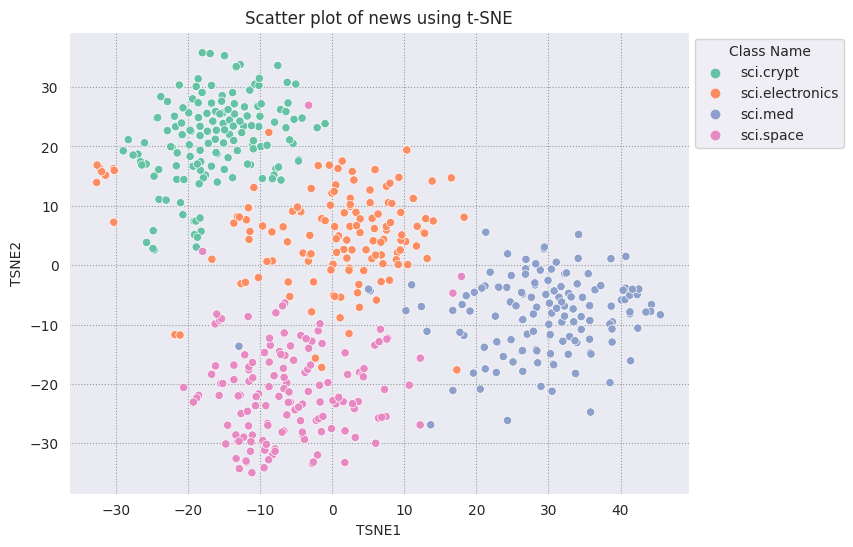

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [ ]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-15.899219,21.129622
sci.electronics,-0.609658,5.234158
sci.med,29.365065,-8.778655
sci.space,-5.070405,-21.039291


In [ ]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [ ]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

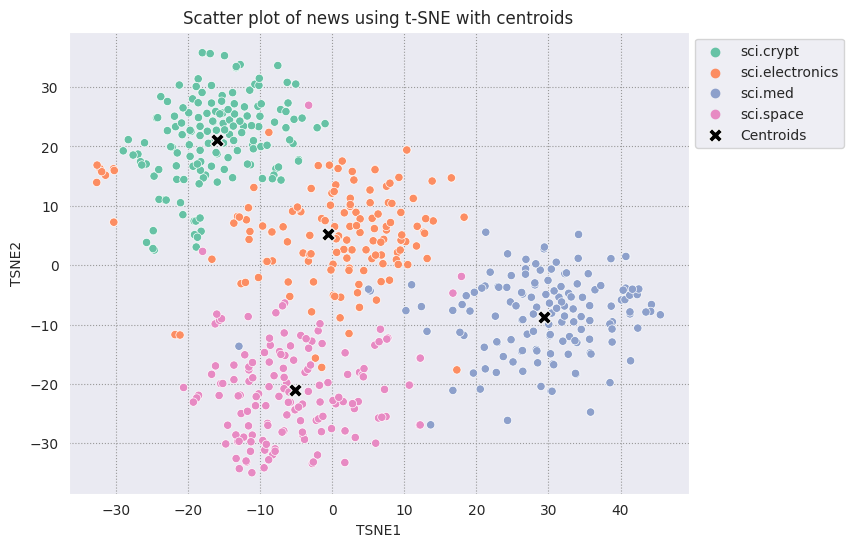

In [ ]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [ ]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [ ]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

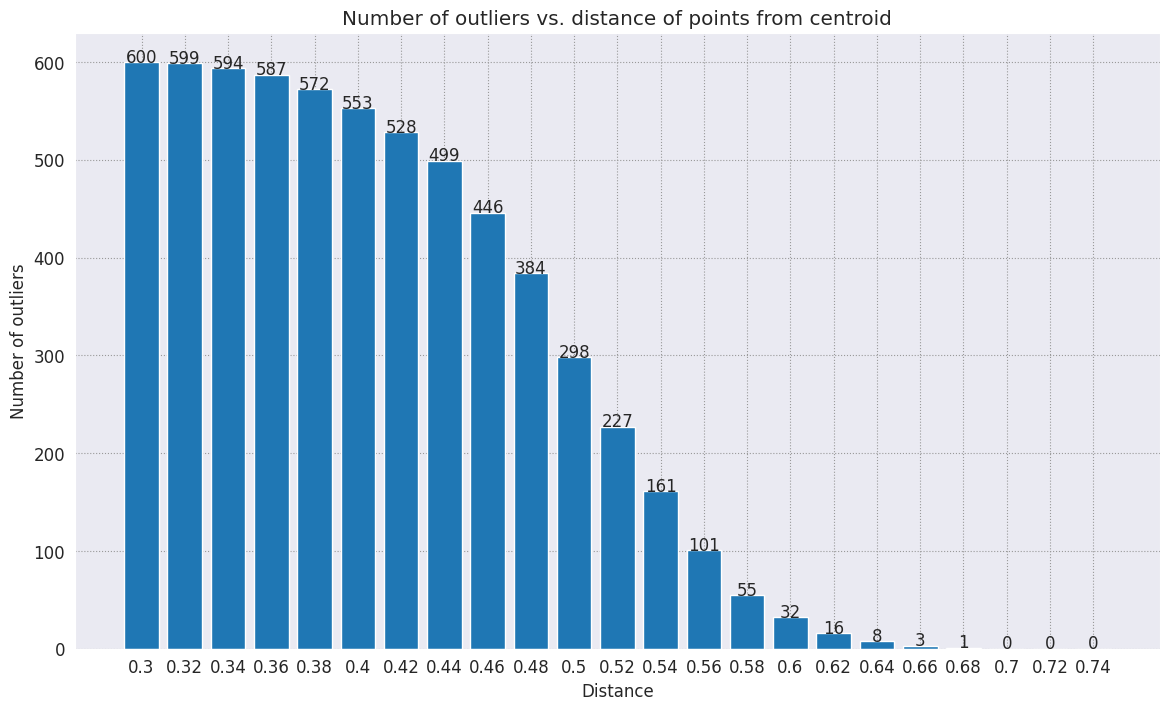

In [ ]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.58 is used, but you can change this value.

In [ ]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
19,Re: **Sorry folks** \nOriginator: \nNntp-Post...,11,sci.crypt,"[-0.0032022626, -0.040697347, 0.025153195, -0....",True
23,freely distributable public key cryptography ...,11,sci.crypt,"[0.016041335, -0.031121235, 0.028244283, 0.030...",True
171,Re: Does someone know what is the news group ...,12,sci.electronics,"[0.047017973, -0.0058603217, -0.026950218, 0.0...",True
176,Re: What do Nuclear Site's Cooling Towers do?...,12,sci.electronics,"[-0.027654478, -0.016448569, -0.015691927, 0.0...",True
194,Read only if going to ISCAS93 in Chicago\nKey...,12,sci.electronics,"[-0.0005354147, -0.034046683, -0.003146662, 0....",True


In [ ]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

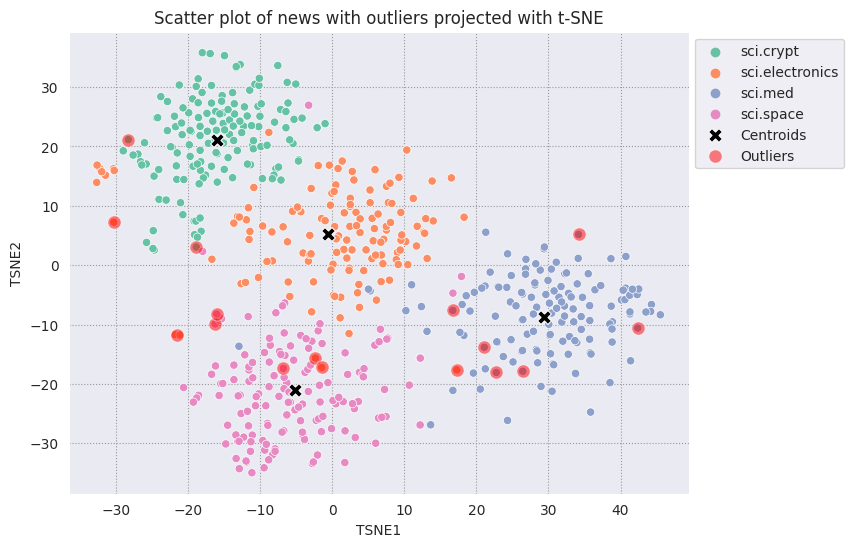

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [ ]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

 Re: **Sorry folks** 
Originator: 
Nntp-Posting-Host: eff.org
Organization: Enormes_Rebajas_Online
Distribution: na
Lines: 15

In article <>   writes:

>I just found out from my source that this article was a joke.  Heh heh..  
>It seemed pretty damn convincing to me from the start -- I just didn't
>notice the smiley at the end of the article, and there were a few other
>hints which I should of caught.

	People took this article seriously?  I mean, I know it's the
Net and all, but the prankster didn't even have Clinton's sound-bites
right.


-- 
Rita Rouvalis




In [ ]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

 Re: Does someone know what is the news group for IEEE.
Reply-To: 
Distribution: usa
Organization: SFBAC
Lines: 11
X-Newsreader: Helldiver 1.07 

In <>   writes:
>            Thanks a lot.

ieee.general

and

ieee.announce


are the most frequently used groups.



In [ ]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

 Re: Can men get yeast infections?
Lines: 13

 To:  

 LB> I know from personal experience that men CAN get yeast infections. I 
 LB> get rather nasty ones from time to time, mostly in the area of the
 LB> scrotum and the base of the penis. 

I used to have problems with recurrent athlete's foot until I 
started drying between my toes with my blow drier after each time 
I bathe.  I also dry my pubic area while I am at it to prevent 
problems.  You might want to try it.

... My cat types with his tail.
 * Origin: ONE WORLD Los Angeles 310/372-0987 32b 



In [ ]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 Stereo Pix of planets?
Organization: California State University, Sacramento
Lines: 5

Can anyone tell me where I might find stereo images of planetary and
planetary satellite surfaces?  GIFs preferred, but any will do.  I'm
especially interested in stereos of the surfaces of Phobos, Deimos, Mars
and the Moon .
  Thanks. 



## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that TSNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis){:.external}.

To learn more about how you can use the embeddings, check out the examples available. To learn how to create them from scratch, see TensorFlow's [Word Embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial. To learn how to use other services in the PaLM API, visit the various quickstart guides:

* [Chat quickstart](../tutorials/chat_quickstart.ipynb)

* [Text generation quickstart](../tutorials/text_quickstart.ipynb)